In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from matplotlib.colors import TABLEAU_COLORS

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test_recommendations

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

data = pd.read_csv('data.csv')
data.columns = ['user', 'item', 'score', 'timestamps']
data = Data(data, implicit=False)

os.chdir('Movielens')

MovieLens data prepared: 6040 users, 3706 items.
951889 Train interactions, 24160 validation and test interactions.


# ExplicitMF (FunkSVD)

In [3]:
for wd in [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0]:
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=wd)
    train(model, data, path='checkpoints/baseline', name=f'wd={wd}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Ensemble

In [2]:
for i in range(2):
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Resample

In [4]:
og = deepcopy(data.train)
for i in range(3):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Zhu et. al

In [2]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test = og[test_idx]
    data.train = og[train_idx]
    model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=model.weight_decay)
    train(model_, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model_.predict(torch.tensor(test[:, 0]).long(), torch.tensor(test[:, 1]).long()) - test[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=0)
train(model, data, path='checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=0.0001)
train(model, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | user_bias | Embedding | 6.0 K 
1 | item_bias | Embedding | 3.7 K 
----------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

tensor(0.2954, device='cuda:0', dtype=torch.float64)

# CPMF

In [2]:
for wd in [0.001]:
    for lr in [0.00001]:
        model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_var=lr)
        train(model, data, path='checkpoints/cpmf', name=f'wd={wd}-lr={lr}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | var_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# OrdRec

In [2]:
data.to_ordinal()
for wd in [0.001]:
    for lr in [0.0005]:
        model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_step=lr)
        train(model, data, path='checkpoints/ordrec', name=f'wd={wd}-lr={lr}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_step       | Embedding | 24.2 K
----------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# BeMF

In [ ]:
data.to_ordinal()
for wd in [0.01, 0.001, 0]:
    for lr in [0.05, 0.01, 0.005]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=50, lr=lr, weight_decay=wd)
        train(model, data, path='checkpoints/bemf', name=f'wd={wd}-lr={lr}')

# Results

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'RMSE': 1.1066662843426027,
 'RPI': 0.3874476802994084,
 'Classification': 0.5977828530060397,
 'Quantile RMSE': array([0.92607553, 1.01560669, 1.06144036, 1.02170161, 0.99585233,
        0.99585233, 1.02129641, 1.0086546 , 1.04612182, 1.05439792,
        1.05203996, 1.11060511, 1.07075823, 1.14907103, 1.15410296,
        1.14075611, 1.21115128, 1.21524532, 1.34552238, 1.41098777]),
 'Precision': array([0.00629139, 0.00496689, 0.0040287 , 0.00368377]),
 'Recall': array([0.00157285, 0.00248344, 0.00302152, 0.00368377]),
 'NDCG': array([0.00629139, 0.01335159, 0.01882108, 0.02422604]),
 'Uncertainty': array([0.66143956, 0.70801434, 0.7080688 , 0.70829593, 0.70833524,
        0.70849128, 0.70829909, 0.70687869, 0.70810503, 0.70726418,
        0.70806986, 0.7077653 , 0.70715485, 0.70841176, 0.70784109,
        0.70711212, 0.70779806, 0.70808116, 0.70900835, 0.70856669]),
 'RRI': array([0.71401064, 0.40958824, 0.27468362, 0.23449714]),
 'Cuts Precision': array([0.00368377, 0.0040149 , 0.00

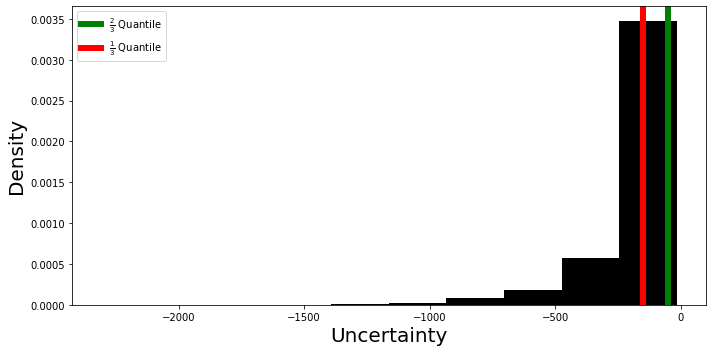

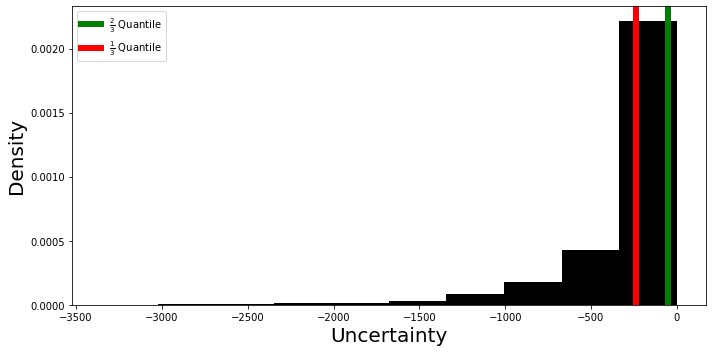

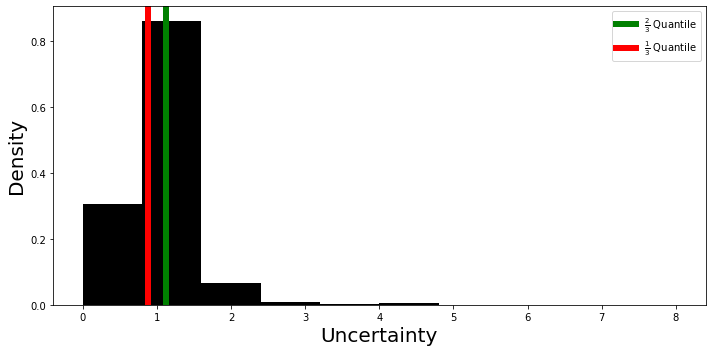

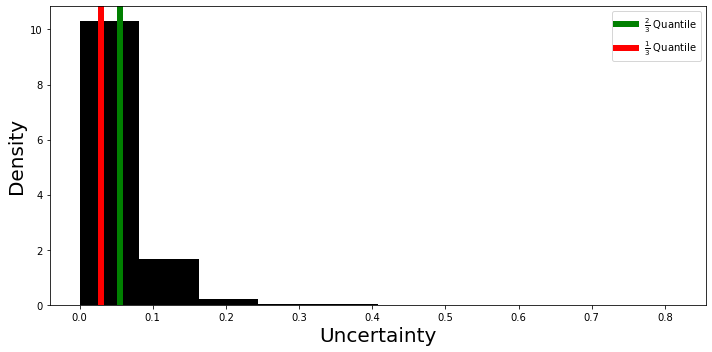

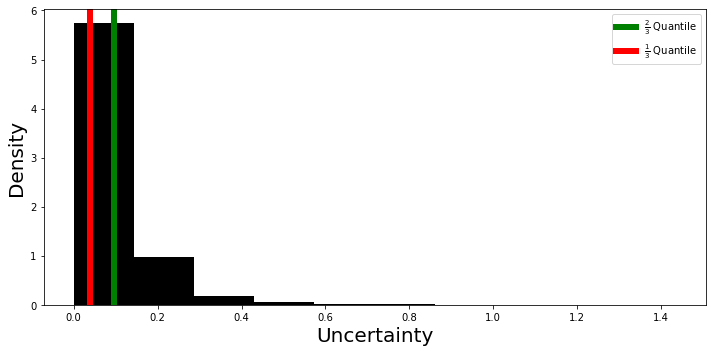

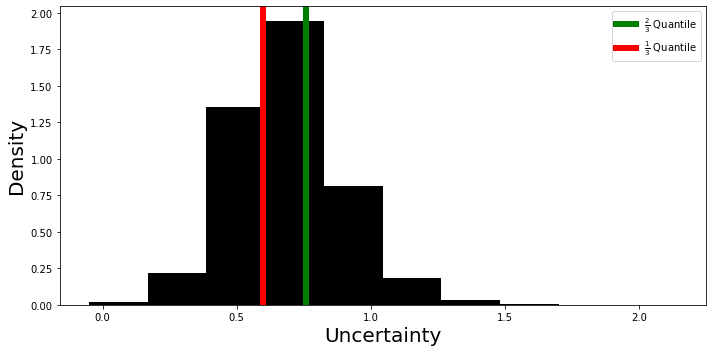

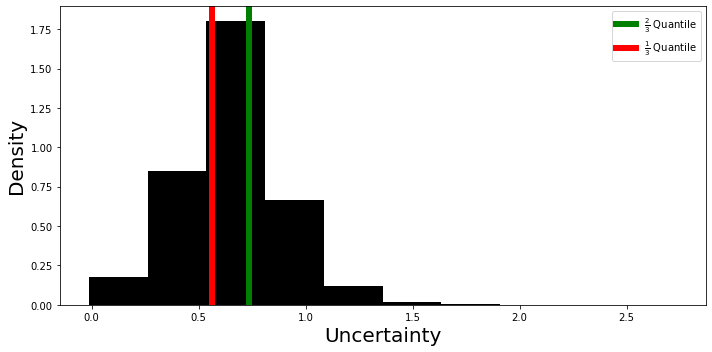

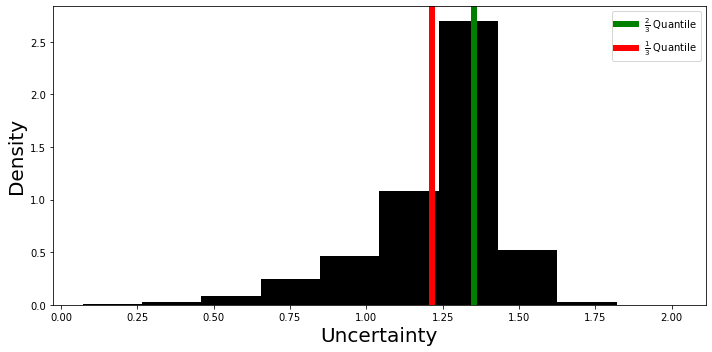

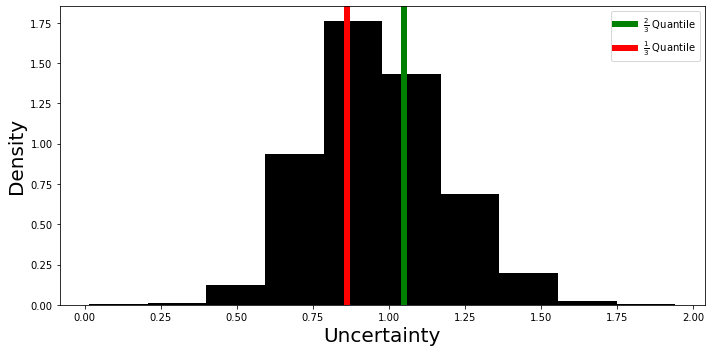

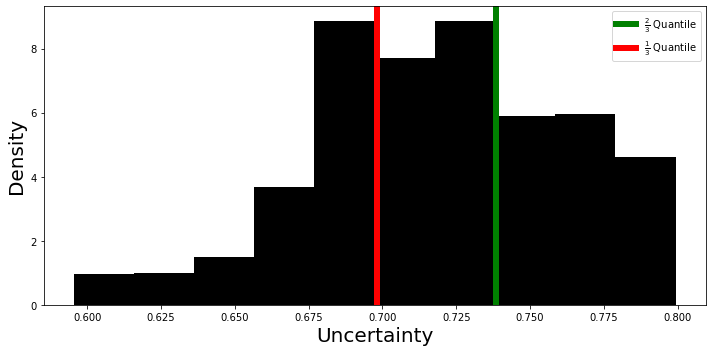

In [2]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test_recommendations(model, data, name='Baseline', max_k=4)

# Heuristics
user_support = np.bincount(data.train_val.user)
item = data.train_val.groupby('item').agg({'user': 'size', 'score': 'var'})
empty = np.where(~pd.Series(np.arange(data.n_item)).isin(item.index))[0]
empty = pd.DataFrame(np.full((len(empty), 2), float('NaN')), index=empty, columns=['user', 'score'])
item = item.append(empty).sort_index().fillna(0).to_numpy()
test_recommendations(UserHeuristic(base_MF=model, uncertainty=-user_support), data, name='User_support', max_k=4)
test_recommendations(ItemHeuristic(base_MF=model, uncertainty=-item[:, 0]), data, name='Item_support', max_k=4)
test_recommendations(ItemHeuristic(base_MF=model, uncertainty=item[:, 1]), data, name='Item_variance', max_k=4)

# Ensemble
models = [model]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test_recommendations(ensemble, data, name='Ensemble', max_k=4)

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(model, models)
test_recommendations(resample, data, name='Resample', max_k=4)

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(model, bias)
test_recommendations(bias_cv, data, name='CV-Bias', max_k=4)
mf_cv = UncertainWrapper(model, mf)
test_recommendations(mf_cv, data, name='CV-PMF', max_k=4)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test_recommendations(model, data, name='CPMF', max_k=4)

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test_recommendations(model, data, name='OrdRec', max_k=4)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test_recommendations(model, data, name='BeMF', max_k=4)

                   RMSE       RPI  Classification
OrdRec         0.914908  0.793502        0.663337
CPMF           0.918597  0.338601        0.562926
User support   0.914617  0.142606        0.538099
Item support   0.914617  0.111727        0.530833
Baseline       0.914617       NaN             NaN
Item variance  0.914617  0.375070        0.579331
CV-PMF         0.914617  0.705338        0.629093
Resample       0.914617  0.213814        0.528760
BeMF           1.106666  0.387448        0.597783
CV-Bias        0.914617  0.735146        0.634119
Ensemble       0.910462  0.236107        0.530957


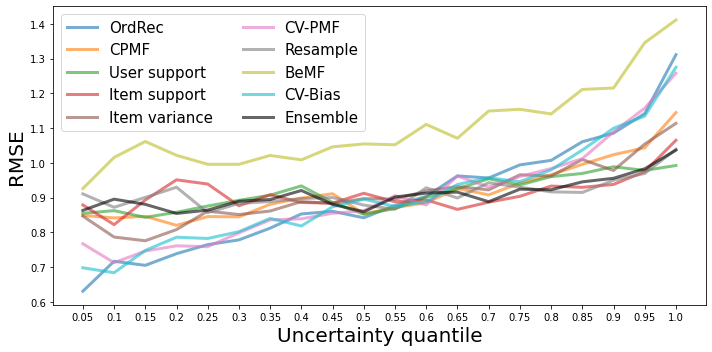

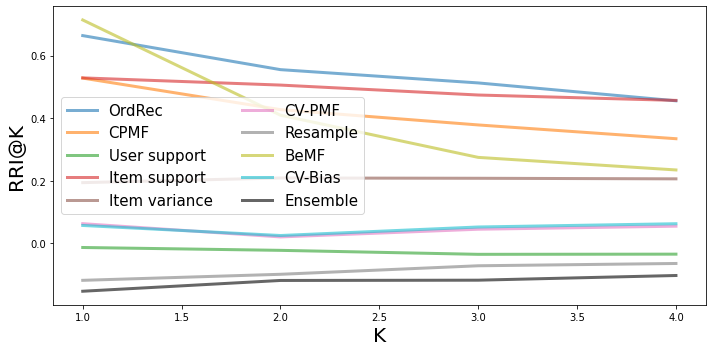

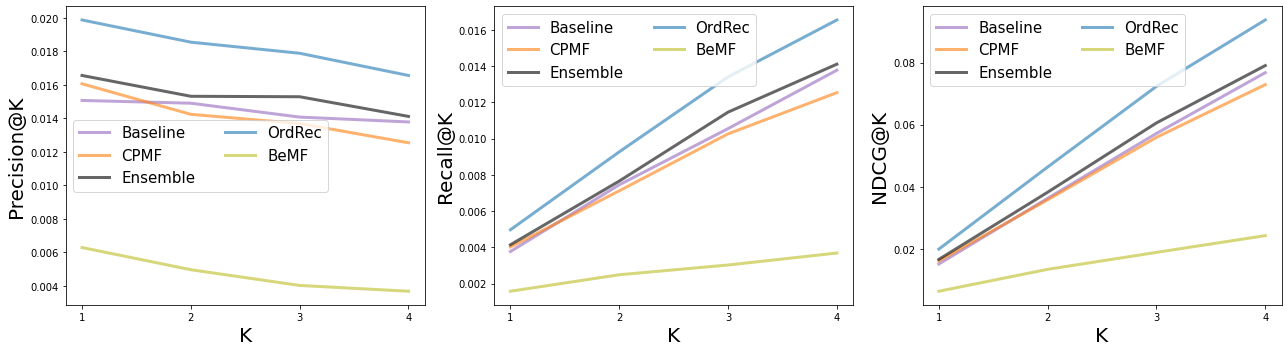

In [10]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results_df = pd.DataFrame.from_dict(results, orient='index')
keys = results_df.index.to_list()
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {keys[i]:colors[i] for i in range(len(keys))}

# Rating prediction evaluation
ratings = results_df[['RMSE', 'RPI', 'Classification']]
print(ratings)

# Uncertainty-RMSE curve
keys = [key for key in results_df.index.to_list() if key != 'Baseline']
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 21), results_df['Quantile RMSE'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# RRI
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 5), results_df['RRI'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('RRI@K', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RRI.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'Ensemble', 'OrdRec', 'BeMF']
f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 5), results_df['Precision'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 5), results_df['Recall'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 5), results_df['NDCG'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 5))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

In [11]:
# Rating prediction evaluation
cols = [col for col in results_df.columns if 'Cuts' in col]
results_df = results_df.drop('Baseline')
for col in cols:
    print('\n', col)
    print(pd.DataFrame(np.vstack(results_df[col].to_numpy()), index=results_df.index, columns=['Base', 'Cut 1/3', 'Cut 2/3']))


 Cuts Precision
                   Base   Cut 1/3   Cut 2/3
OrdRec         0.016556  0.016244  0.015748
CPMF           0.012541  0.014818  0.016018
User support   0.013562  0.012825  0.012989
Item support   0.013783  0.014570  0.016060
Item variance  0.013783  0.013411  0.011796
CV-PMF         0.013783  0.011134  0.005919
Resample       0.013783  0.011465  0.009478
BeMF           0.003684  0.004015  0.004512
CV-Bias        0.013783  0.010980  0.006867
Ensemble       0.014114  0.009313  0.006623

 Cuts Coverage
                   Base   Cut 1/3   Cut 2/3
OrdRec         1.000000  0.998841  0.988245
CPMF           1.000000  1.000000  1.000000
User support   0.985762  0.661589  0.334603
Item support   1.000000  1.000000  1.000000
Item variance  1.000000  1.000000  1.000000
CV-PMF         1.000000  1.000000  1.000000
Resample       1.000000  1.000000  1.000000
BeMF           1.000000  1.000000  1.000000
CV-Bias        1.000000  0.995199  0.982450
Ensemble       1.000000  1.000000  1.000000